In [88]:
import random
import math
import matplotlib.pyplot as plt
import time
import random
import math
import matplotlib.pyplot as plt
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# Utility functions

#####  Function to calculate angle between two points in degrees

In [89]:
def calculate_angle(uav1_pos, uav2_pos):
    delta_y = uav2_pos[1] - uav1_pos[1]
    delta_x = uav2_pos[0] - uav1_pos[0]
    angle = math.degrees(math.atan2(delta_y, delta_x))
    return angle if angle >= 0 else angle + 360

#####  Function to check if a UAV is within beamforming angle

In [90]:
def within_beamforming_angle(uav1_angle, uav2_angle, beamwidth=30):
    # Check if the angle between UAVs is within the beamwidth (30 degrees here as an example)
    return abs(uav1_angle - uav2_angle) <= beamwidth / 2

##### distance between uav/ue

In [91]:
# Function to calculate distance between two points
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

##### Function to find users covered by a UAV at a given position

In [92]:
def users_covered_by_uav(uav_pos, users, coverage_radius):
    covered_users = []
    for user in users:
        if distance(uav_pos, user.position) <= coverage_radius:
            covered_users.append(user)  # Append User objects
    return covered_users

##### Function to simulate random walk for users

In [93]:
def move_users(users, m, n, step_size=0.5):
    for user in users:
        # Update x and y positions
        user.position[0] += random.uniform(-step_size, step_size)
        user.position[1] += random.uniform(-step_size, step_size)
        
        # Ensure users stay within grid boundaries
        user.position[0] = max(0, min(user.position[0], m))
        user.position[1] = max(0, min(user.position[1], n))

##### Visulization

In [94]:
def visualize_grid(m, n, users, selected_uavs, coverage_radius, time_step):
    plt.figure(figsize=(10, 10))
    
    # Plot users
    for user in users:
        plt.plot(user.position[0], user.position[1], 'bo', label='User' if users.index(user) == 0 else "")

    # Plot UAV coverage
    for uav in selected_uavs:
        circle = plt.Circle(uav.position, uav.coverage_radius, color='r', alpha=0.3, label='UAV Coverage' if selected_uavs.index(uav) == 0 else "")
        plt.gca().add_patch(circle)
        plt.plot(uav.position[0], uav.position[1], 'rx', markersize=10, label='UAV Position' if selected_uavs.index(uav) == 0 else "")
    
    # Plot UAV backhaul connections
    for uav in selected_uavs:
        for connected_uav in uav.connected_uavs:
            plt.plot([uav.position[0], connected_uav.position[0]], [uav.position[1], connected_uav.position[1]], 'g--', label='Backhaul Link' if uav == selected_uavs[0] and connected_uav == list(uav.connected_uavs)[0] else "")

    # Set plot limits and labels
    plt.xlim(0, m)
    plt.ylim(0, n)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.xlabel('Grid X')
    plt.ylabel('Grid Y')
    plt.title(f'UAV Coverage and Backhaul on Grid at Time Step {time_step}')
    plt.legend()
    plt.show()

# UAV class

In [95]:
class UAV:
    def __init__(self, position, coverage_radius, backhaul_range,beamwidth):
        self.position = position  # [x, y]
        self.coverage_radius = coverage_radius
        self.backhaul_range = backhaul_range
        self.beamwidth = beamwidth  # Directional beamwidth in degrees
        self.covered_users = set()       # Set of User objects
        self.connected_uavs = set()      # Set of UAV objects
        self.beam_angle = 0  # Direction in which UAV is pointing its beam

    def update_coverage(self, users):
        self.covered_users = set()
        for user in users:
            if distance(self.position, user.position) <= self.coverage_radius:
                self.covered_users.add(user)
                user.connect_to_uav(self)

    def update_backhaul_connections(self, uavs):
        potential_connections = []
        for uav in uavs:
            if uav != self and distance(self.position, uav.position) <= self.backhaul_range:
                potential_connections.append(uav)

        # Sort potential connections by distance (closest first)
        potential_connections.sort(key=lambda uav: distance(self.position, uav.position))

        # Update the beam angle towards the closest UAV
        if potential_connections:
            closest_uav = potential_connections[0]
            self.beam_angle = calculate_angle(self.position, closest_uav.position)

            # Connect only to UAVs within the beamforming angle
            for uav in potential_connections:
                uav_angle = calculate_angle(self.position, uav.position)
                if within_beamforming_angle(self.beam_angle, uav_angle, self.beamwidth):
                    self.connected_uavs.add(uav)

    def print_statistics(self):
        print(f"UAV Position: {self.position}")
        print(f"Beam Angle: {self.beam_angle:.2f} degrees")
        print(f"Number of Covered Users: {len(self.covered_users)}")
        print(f"Connected UAVs: {[uav.position for uav in self.connected_uavs]}")
        print("--------")
    

    def place_uavs_greedy(m, n, users, coverage_radius, coverage_threshold=0.9):
        uav_positions = [(i, j) for i in range(m) for j in range(n)]
        selected_uavs = []
        covered_users = set()
        total_users = len(users)
        required_coverage = coverage_threshold * total_users

        uav_cover_dict = []
    
        while len(covered_users) < required_coverage:
            best_uav = None
            best_covered_users = set()

            for uav_pos in uav_positions:
                current_covered_users = set(users_covered_by_uav(uav_pos, users, coverage_radius))
                new_covered_users = current_covered_users - covered_users

                penalty = 0

                if len(uav_cover_dict) >= 0:
                    for cov_users in uav_cover_dict:
                        penalty += len(cov_users) -  len(cov_users - best_covered_users)

                penalty = 0.3 * penalty    
                
                if len(new_covered_users) > len(best_covered_users):
                    best_uav = uav_pos
                    best_covered_users = new_covered_users

            if best_uav is None:
                break

            selected_uavs.append(best_uav)
            covered_users.update(best_covered_users)
            uav_positions.remove(best_uav)
            uav_cover_dict.append(best_covered_users)
    
        return selected_uavs, covered_users



# USER Class

In [96]:
# User Class
class User:
    def __init__(self, position):
        self.position = position  # position is a list [x, y]
        self.connected_uav = None

    def connect_to_uav(self, uav):
        self.connected_uav = uav

# Function to generate random user objects
    def generate_random_users(m, n, num_users):
        users = []
        for _ in range(num_users):
            x = random.uniform(0, m)
            y = random.uniform(0, n)
            users.append(User([x, y]))  # Create User objects
        return users

# Beamforming

# Simulation 

In [97]:
# Simulation parameters
m, n = 10, 10  # Grid size
num_users = 100  # Number of users
coverage_radius = 2.5  # Coverage radius of each UAV
backhaul_range = 8.0  # Backhaul connection range between UAVs
time_steps = 10  # Number of time steps to simulate
min_threshold=0.88 #minimum threshold value of user coverage

In [98]:
# Generate random users
users = User.generate_random_users(m, n, num_users)
# Place UAVs using the greedy algorithm based on initial user distribution
selected_positions, covered_users = UAV.place_uavs_greedy(m, n, [user for user in users], coverage_radius)
# Update the UAVs in the simulation code to use beamforming
uavs = [UAV(position=pos, coverage_radius=coverage_radius, backhaul_range=backhaul_range, beamwidth=30) for pos in selected_positions]



Initial UAV placement:
Covered users: 91
Coverage percentage: 91.00%


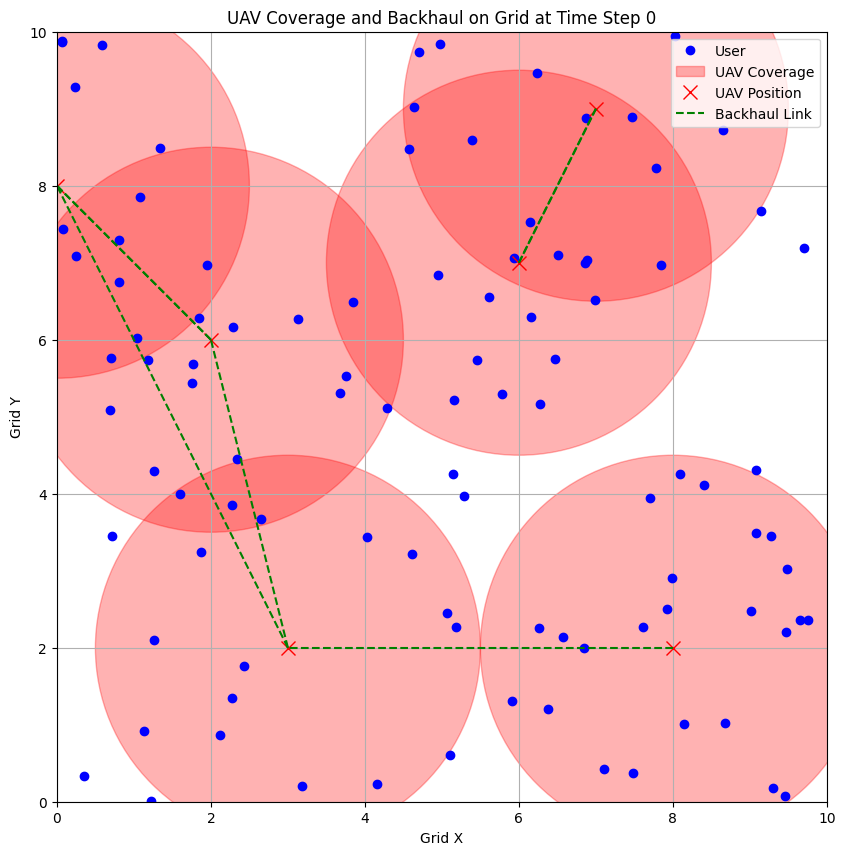

In [99]:
# Initial coverage and backhaul setup
for uav in uavs:
    uav.update_coverage(users)
    uav.update_backhaul_connections(uavs)

# Print initial coverage stats
print(f"Initial UAV placement:")
print(f"Covered users: {len(covered_users)}")
print(f"Coverage percentage: {len(covered_users) / num_users * 100:.2f}%")
# Initial visualization
visualize_grid(m, n, users, uavs, coverage_radius, time_step=0)

Time Step 1:
Covered users: 89
Coverage percentage: 89.00%
UAV Position: (2, 6)
Beam Angle: 135.00 degrees
Number of Covered Users: 22
Connected UAVs: [(0, 8)]
--------
UAV Position: (8, 2)
Beam Angle: 180.00 degrees
Number of Covered Users: 24
Connected UAVs: [(3, 2)]
--------
UAV Position: (6, 7)
Beam Angle: 63.43 degrees
Number of Covered Users: 22
Connected UAVs: [(7, 9)]
--------
UAV Position: (3, 2)
Beam Angle: 104.04 degrees
Number of Covered Users: 16
Connected UAVs: [(2, 6), (0, 8)]
--------
UAV Position: (0, 8)
Beam Angle: 315.00 degrees
Number of Covered Users: 13
Connected UAVs: [(2, 6)]
--------
UAV Position: (7, 9)
Beam Angle: 243.43 degrees
Number of Covered Users: 15
Connected UAVs: [(6, 7)]
--------


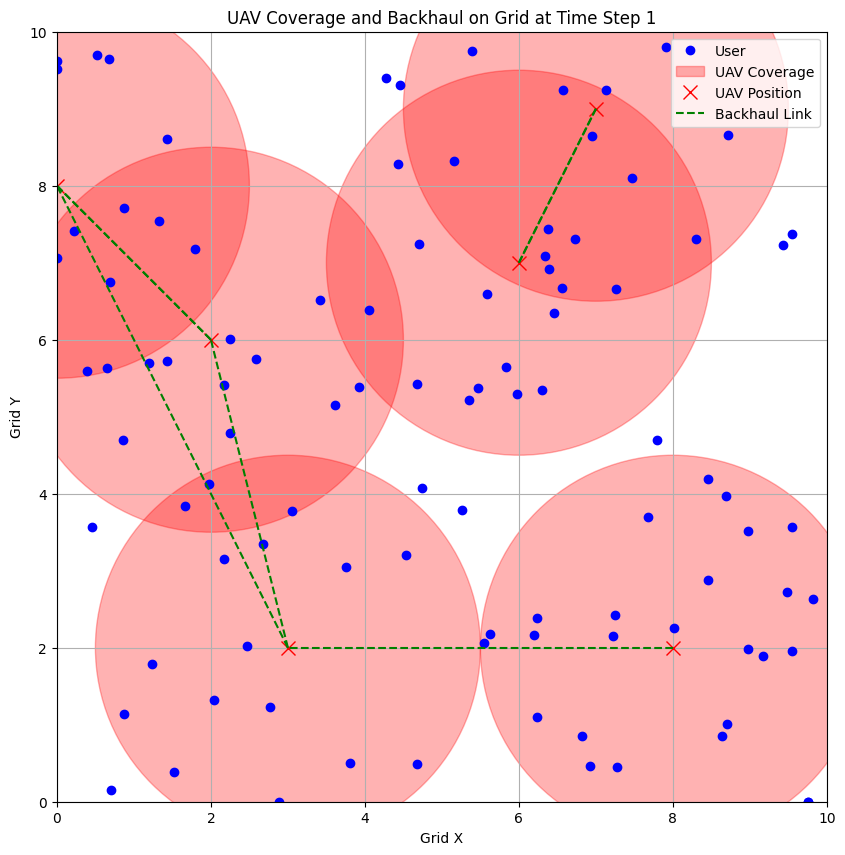

Time Step 2:
Covered users: 89
Coverage percentage: 89.00%
UAV Position: (2, 6)
Beam Angle: 135.00 degrees
Number of Covered Users: 22
Connected UAVs: [(0, 8)]
--------
UAV Position: (8, 2)
Beam Angle: 180.00 degrees
Number of Covered Users: 24
Connected UAVs: [(3, 2)]
--------
UAV Position: (6, 7)
Beam Angle: 63.43 degrees
Number of Covered Users: 23
Connected UAVs: [(7, 9)]
--------
UAV Position: (3, 2)
Beam Angle: 104.04 degrees
Number of Covered Users: 15
Connected UAVs: [(2, 6), (0, 8)]
--------
UAV Position: (0, 8)
Beam Angle: 315.00 degrees
Number of Covered Users: 14
Connected UAVs: [(2, 6)]
--------
UAV Position: (7, 9)
Beam Angle: 243.43 degrees
Number of Covered Users: 17
Connected UAVs: [(6, 7)]
--------


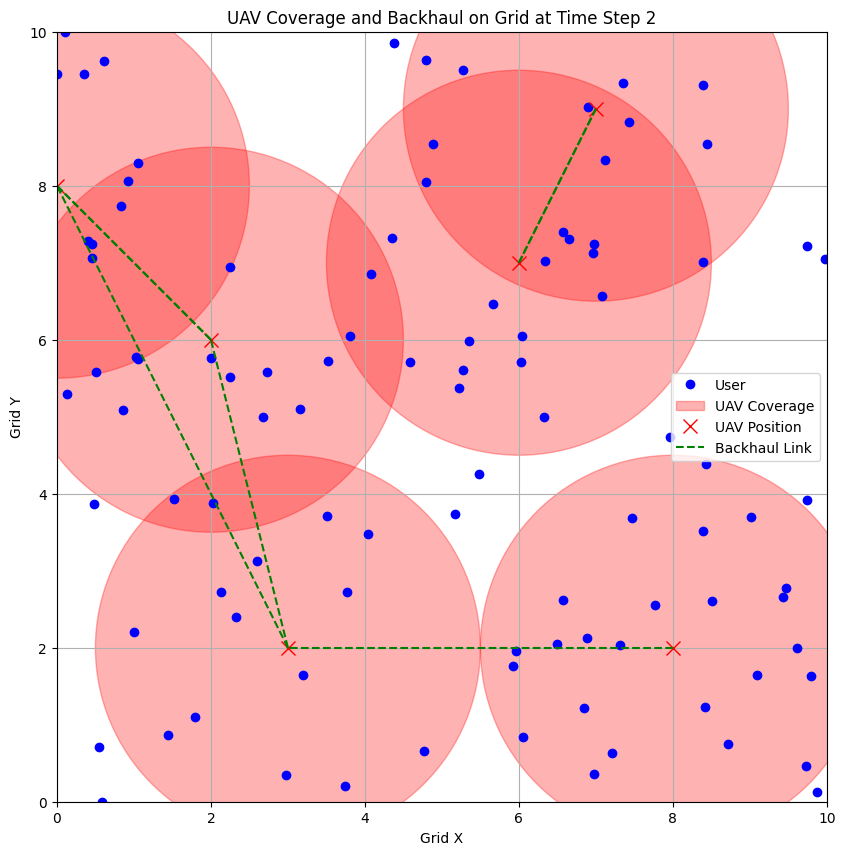

Time Step 3:
Covered users: 92
Coverage percentage: 92.00%
UAV Position: (2, 6)
Beam Angle: 135.00 degrees
Number of Covered Users: 23
Connected UAVs: [(0, 8)]
--------
UAV Position: (8, 2)
Beam Angle: 180.00 degrees
Number of Covered Users: 27
Connected UAVs: [(3, 2)]
--------
UAV Position: (6, 7)
Beam Angle: 63.43 degrees
Number of Covered Users: 23
Connected UAVs: [(7, 9)]
--------
UAV Position: (3, 2)
Beam Angle: 104.04 degrees
Number of Covered Users: 14
Connected UAVs: [(2, 6), (0, 8)]
--------
UAV Position: (0, 8)
Beam Angle: 315.00 degrees
Number of Covered Users: 11
Connected UAVs: [(2, 6)]
--------
UAV Position: (7, 9)
Beam Angle: 243.43 degrees
Number of Covered Users: 15
Connected UAVs: [(6, 7)]
--------


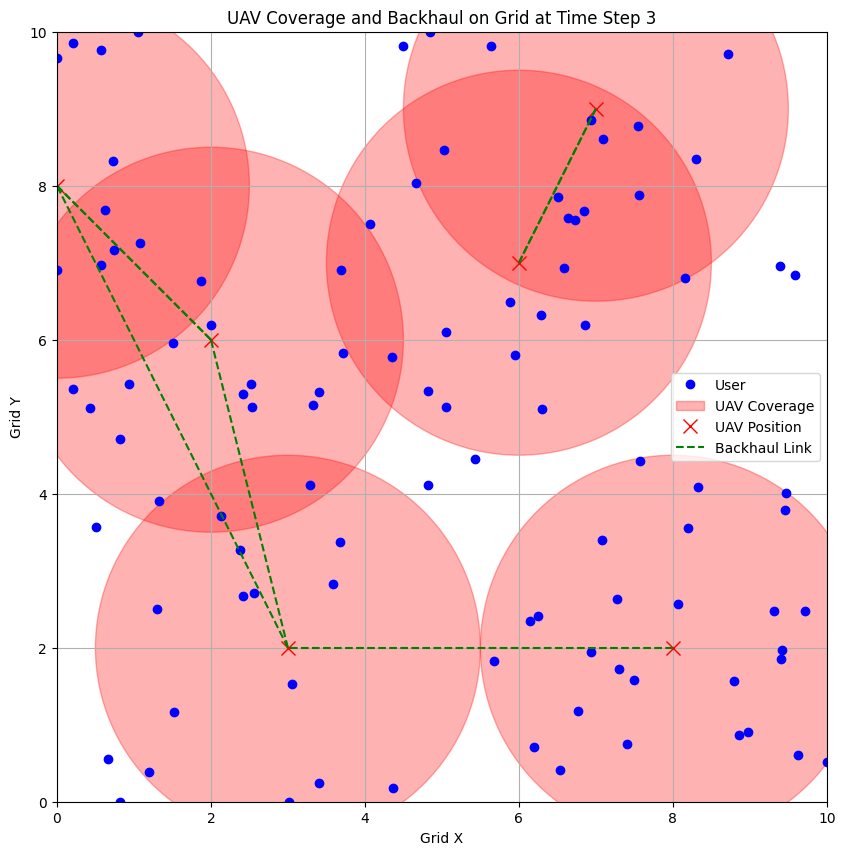

Time Step 4:
Covered users: 91
Coverage percentage: 91.00%
UAV Position: (2, 6)
Beam Angle: 135.00 degrees
Number of Covered Users: 23
Connected UAVs: [(0, 8)]
--------
UAV Position: (8, 2)
Beam Angle: 180.00 degrees
Number of Covered Users: 25
Connected UAVs: [(3, 2)]
--------
UAV Position: (6, 7)
Beam Angle: 63.43 degrees
Number of Covered Users: 23
Connected UAVs: [(7, 9)]
--------
UAV Position: (3, 2)
Beam Angle: 104.04 degrees
Number of Covered Users: 14
Connected UAVs: [(2, 6), (0, 8)]
--------
UAV Position: (0, 8)
Beam Angle: 315.00 degrees
Number of Covered Users: 12
Connected UAVs: [(2, 6)]
--------
UAV Position: (7, 9)
Beam Angle: 243.43 degrees
Number of Covered Users: 19
Connected UAVs: [(6, 7)]
--------


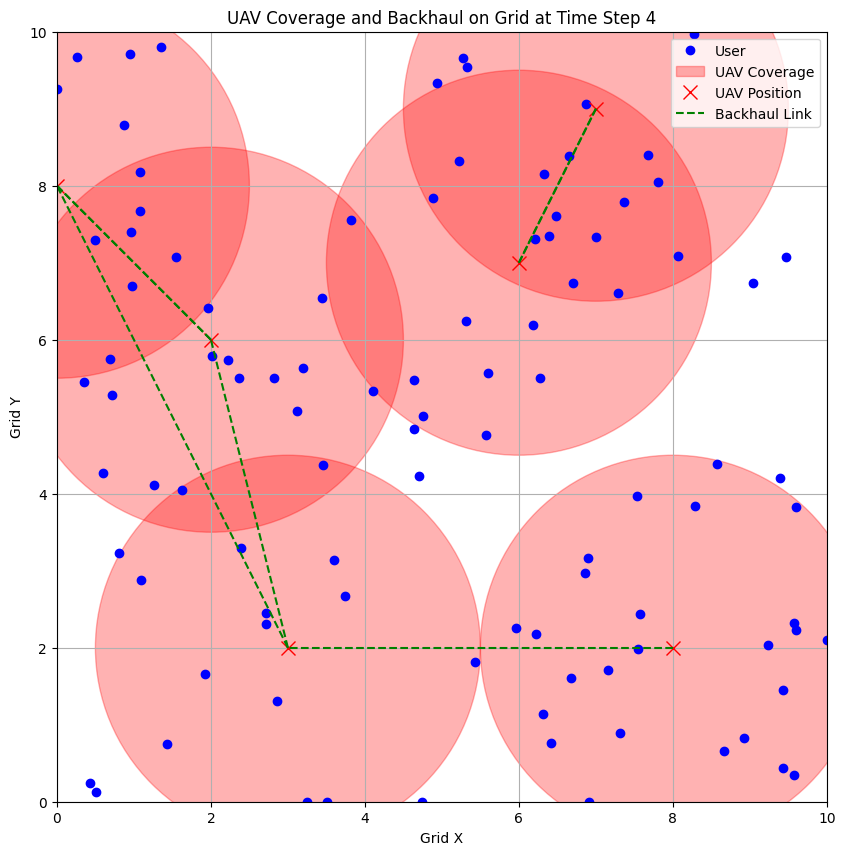

Time Step 5:
Covered users: 89
Coverage percentage: 89.00%
UAV Position: (2, 6)
Beam Angle: 135.00 degrees
Number of Covered Users: 20
Connected UAVs: [(0, 8)]
--------
UAV Position: (8, 2)
Beam Angle: 180.00 degrees
Number of Covered Users: 24
Connected UAVs: [(3, 2)]
--------
UAV Position: (6, 7)
Beam Angle: 63.43 degrees
Number of Covered Users: 24
Connected UAVs: [(7, 9)]
--------
UAV Position: (3, 2)
Beam Angle: 104.04 degrees
Number of Covered Users: 15
Connected UAVs: [(2, 6), (0, 8)]
--------
UAV Position: (0, 8)
Beam Angle: 315.00 degrees
Number of Covered Users: 13
Connected UAVs: [(2, 6)]
--------
UAV Position: (7, 9)
Beam Angle: 243.43 degrees
Number of Covered Users: 18
Connected UAVs: [(6, 7)]
--------


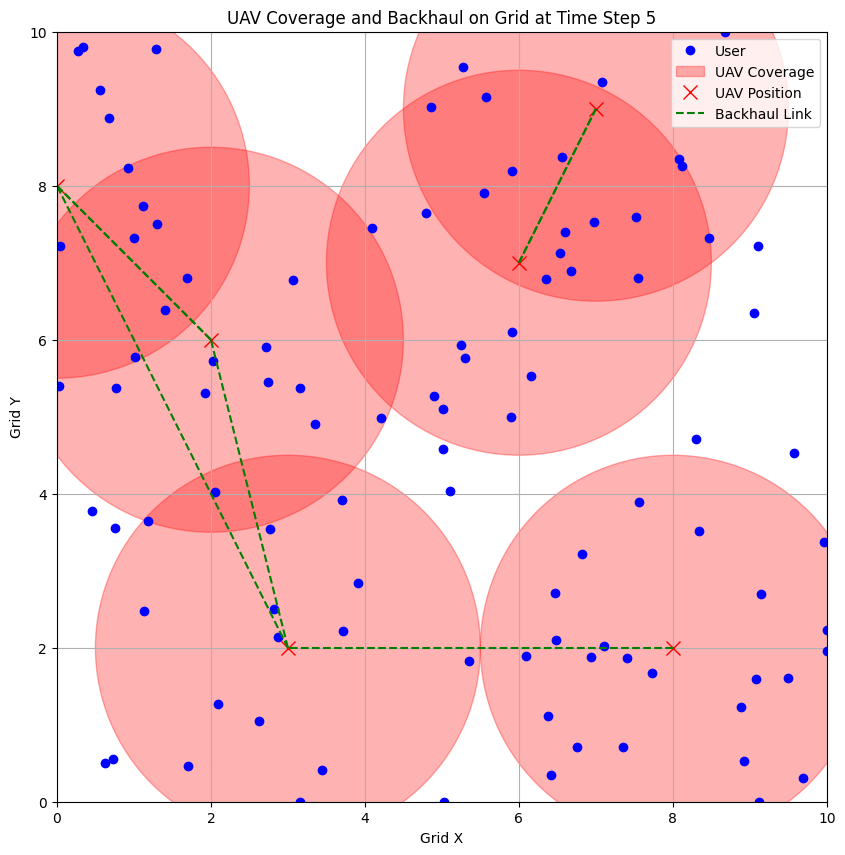

Time Step 6:
Covered users: 90
Coverage percentage: 90.00%
UAV Position: (2, 6)
Beam Angle: 135.00 degrees
Number of Covered Users: 19
Connected UAVs: [(0, 8)]
--------
UAV Position: (8, 2)
Beam Angle: 180.00 degrees
Number of Covered Users: 25
Connected UAVs: [(3, 2)]
--------
UAV Position: (6, 7)
Beam Angle: 63.43 degrees
Number of Covered Users: 24
Connected UAVs: [(7, 9)]
--------
UAV Position: (3, 2)
Beam Angle: 104.04 degrees
Number of Covered Users: 15
Connected UAVs: [(2, 6), (0, 8)]
--------
UAV Position: (0, 8)
Beam Angle: 315.00 degrees
Number of Covered Users: 14
Connected UAVs: [(2, 6)]
--------
UAV Position: (7, 9)
Beam Angle: 243.43 degrees
Number of Covered Users: 16
Connected UAVs: [(6, 7)]
--------


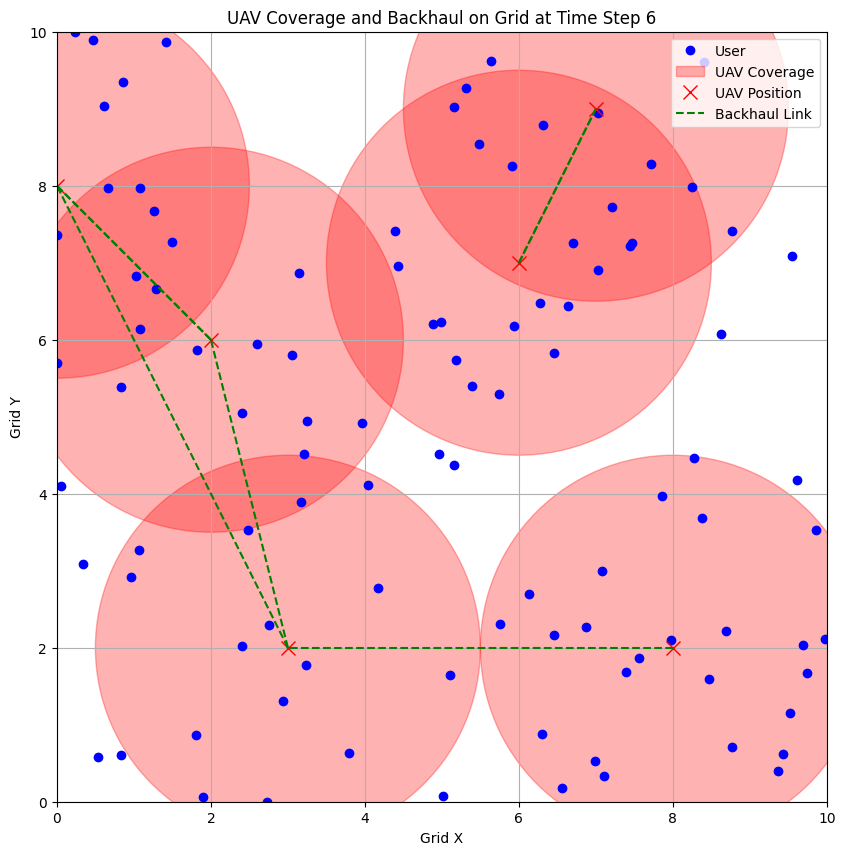

Time Step 7:
Covered users: 87
Coverage percentage: 87.00%

-----------------------------------Reconfiguring UAVs---------------------------------------



TypeError: UAV.__init__() missing 1 required positional argument: 'beamwidth'

In [100]:
# Adjust the coverage threshold check and loop logic in the dynamic simulation
for t in range(1, time_steps + 1):
    move_users(users, m, n)  # Move users according to the mobility model
    
    # Update coverage and backhaul connections
    for uav in uavs:
        uav.update_coverage(users)
        uav.update_backhaul_connections(uavs)
    
    # Recalculate coverage
    covered_users = set()
    for uav in uavs:
        covered_users.update(uav.covered_users)
    
    # Print coverage stats
    print(f"Time Step {t}:")
    print(f"Covered users: {len(covered_users)}")
    print(f"Coverage percentage: {len(covered_users) / num_users * 100:.2f}%")

    # Check if coverage drops below the minimum threshold
    if len(covered_users) / num_users < min_threshold:
        print()
        print("-----------------------------------Reconfiguring UAVs---------------------------------------")
        print()
        
        # Reconfigure UAVs using the greedy algorithm
        selected_positions, covered_users = UAV.place_uavs_greedy(m, n, users, coverage_radius, coverage_threshold=0.9)
        uavs = [UAV(position=pos, coverage_radius=coverage_radius, backhaul_range=backhaul_range) for pos in selected_positions]

        # Update coverage and backhaul after reconfiguration
        for uav in uavs:
            uav.update_coverage(users)
            uav.update_backhaul_connections(uavs)

        # Print new UAV coverage stats after reconfiguration
        print(f"Reconfigured UAV placement:")
        print(f"Covered users: {len(covered_users)}")
        print(f"Coverage percentage: {len(covered_users) / num_users * 100:.2f}%")
        
        # Visualize the new UAV configuration
        visualize_grid(m, n, users, uavs, coverage_radius, time_step=t)
    
    # Print statistics for each UAV
    for uav in uavs:
        uav.print_statistics()
    
    # Visualize the current state
    visualize_grid(m, n, users, uavs, coverage_radius, time_step=t)
    
    # Pause for visualization clarity
    time.sleep(1)
